In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from lesson_functions import *
from scipy.ndimage.measurements import label
%matplotlib inline
import glob
import random
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

In [2]:
# Parameters
target_color_space = 'YCrCb'
orientations = 9
px_per_cell = (8, 8)
cells_per_block = (2, 2)

orient, pix_per_cell, cell_per_block, spatial_size, hist_bins = 9, 8, 2, (32, 32), 32

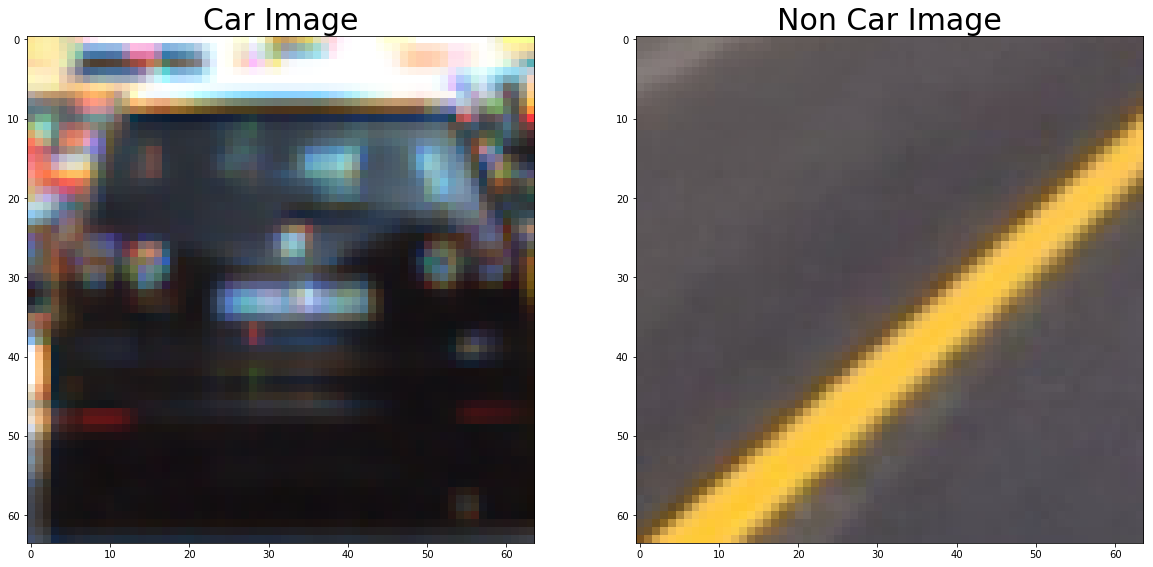

In [3]:
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread(random.choice(car_images)))
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(mpimg.imread(random.choice(noncar_images)))
ax2.set_title('Non Car Image', fontsize=30)

plt.savefig('output_images/car_not_car.png', bbox_inches='tight')

/home/carnd/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


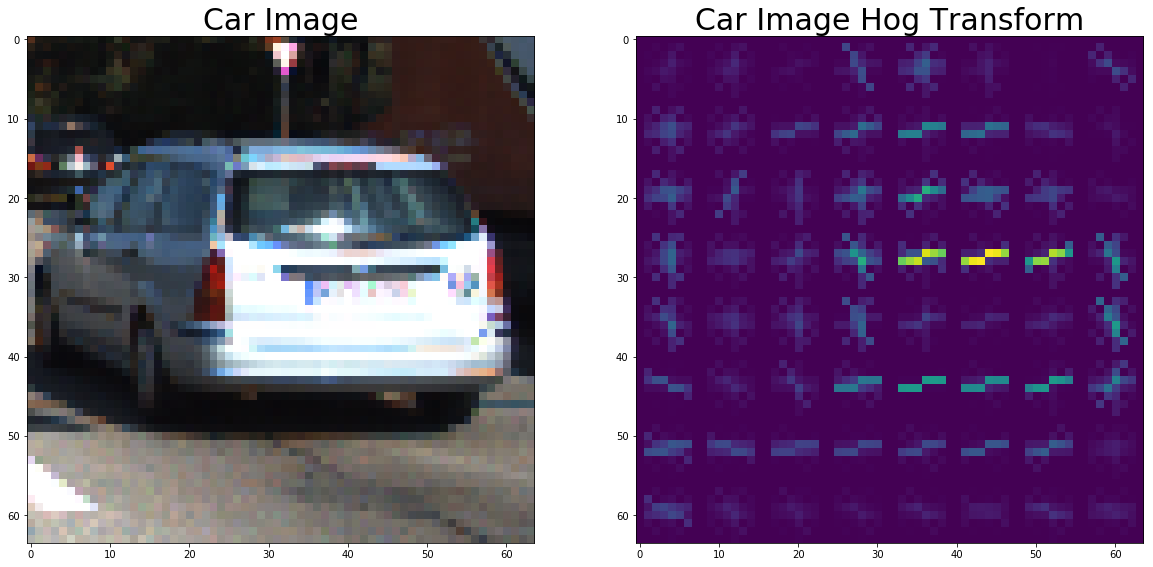

In [12]:
car_ex = mpimg.imread(random.choice(car_images))
car_ex_c = cv2.cvtColor(car_ex, getattr(cv2, "COLOR_RGB2{}".format(target_color_space)))
                        
feats, car_hog = hog(car_ex_c[:,:,0], 
                 orientations=9, 
                 pixels_per_cell=px_per_cell, 
                 cells_per_block=cells_per_block, 
                 visualise=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car_ex)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(car_hog)
ax2.set_title('Car Image Hog Transform', fontsize=30)

plt.savefig('output_images/HOG_example.png', bbox_inches='tight')

In [13]:
car_feats = extract_features(car_images, color_space='YCrCb', 
                             hog_channel='ALL', spatial_feat=False)
noncar_feats = extract_features(noncar_images, color_space='YCrCb', 
                                hog_channel='ALL', spatial_feat=False)

X = np.vstack((car_feats, noncar_feats)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_feats)), np.zeros(len(noncar_feats))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/home/carnd/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.98873873873873874

In [18]:
with open('svc.p', 'wb') as f:
  pickle.dump({'clf': clf, 'X_scaler': X_scaler}, f, -1)

In [4]:
with open('svc.p', 'rb') as f:
    o = pickle.load(f)
    clf = o['clf']
    X_scaler = o['X_scaler']

In [48]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    xy_window, xy_overlap = np.array(xy_window), np.array(xy_overlap)

    x_start = x_start_stop[0] or 0
    x_stop = x_start_stop[1] or img.shape[1]
    y_start = y_start_stop[0] or 0
    y_stop = y_start_stop[1] or img.shape[0]

    span = np.array([x_stop - x_start, y_stop - y_start])

    px_per_step = np.asarray(xy_window * (1 - xy_overlap), dtype=int )

    windows = np.asarray( span/px_per_step - 1 , dtype=int )

    window_list = []
    for x in range(windows[0]):
        for y in range(windows[1]):
            p1 = np.array([x, y]) * px_per_step
            window_list.append((tuple(p1), tuple(p1 + xy_window)))
    return window_list

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

from collections import deque
frame_bboxes = deque([], 6)

def process_heatmap(bbox_list, img, reset=True):
    if reset == True:
        return add_heat(np.zeros((img.shape[0], img.shape[1])), bbox_list)
    else:
        frame_bboxes.append(bbox_list)
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        for bboxes in frame_bboxes:
            add_heat(heatmap, bboxes)
        return apply_threshold(heatmap, len(frame_bboxes))

def draw_labeled_bboxes(img, heatmap):
    global frame_i, vidfig
    src_img = np.copy(img)
    labels = label(heatmap)

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    if frame_i*4+4 <= 24:
        ax1 = vidfig.add_subplot(6, 4, frame_i*4 + 1)
        ax2 = vidfig.add_subplot(6, 4, frame_i*4 + 2)
        ax3 = vidfig.add_subplot(6, 4, frame_i*4 + 3)
        ax4 = vidfig.add_subplot(6, 4, frame_i*4 + 4)

        ax1.imshow(src_img)
        ax2.imshow(heatmap)
        ax3.imshow(labels[0], cmap='gray')
        ax4.imshow(img)
        frame_i += 1
        
    return img

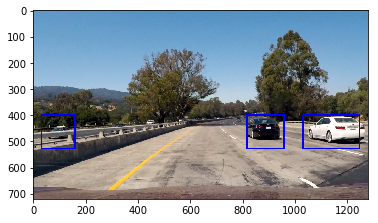

In [59]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, getattr(cv2, "COLOR_RGB2{}".format(target_color_space)))
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
                                   
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return bboxes

def process_cars(img, reset=False):
    ystart = 400
    ystop = 656

    bboxes = find_cars(img, ystart, ystop, 2, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) + find_cars(img, ystart, ystop, 1.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heatmap = process_heatmap(bboxes, img, reset=reset)
    return draw_labeled_bboxes(np.copy(img), heatmap)

def find_cars_draw(img):
    plt.imshow(process_cars(img, reset=True))

test_img = mpimg.imread('test_images/test1.jpg')
find_cars_draw(test_img)
plt.savefig('output_images/image_4.png', bbox_inches='tight')

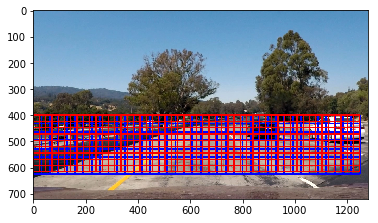

In [58]:
class DummyClf:
    def predict(a, b):
        return True

def draw_windows(img):
    ystart = 400
    ystop = 656
    dummy_clf = DummyClf();
    bboxes1 = find_cars(img, ystart, ystop, 2, dummy_clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes2 = find_cars(img, ystart, ystop, 1.5, dummy_clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    draw_img = np.copy(img)
    out1 = draw_boxes(draw_img, bboxes1)
    out2 = draw_boxes(out1, bboxes2, color=(250, 0, 0), thick=3)
    
    plt.imshow(out2)
    plt.savefig('output_images/image_3.png', bbox_inches='tight')

draw_windows(test_img)

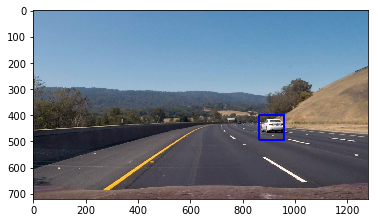

In [60]:
find_cars_draw(mpimg.imread('test_images/test3.jpg'))
plt.savefig('output_images/image_4a.png', bbox_inches='tight')

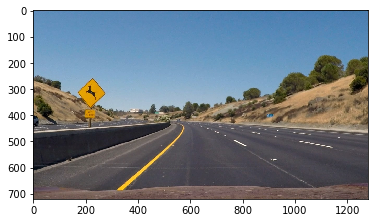

In [61]:
find_cars_draw(mpimg.imread('test_images/test2.jpg'))
plt.savefig('output_images/image_4b.png', bbox_inches='tight')

[MoviePy] >>>> Building video project_video.mp4
[MoviePy] Writing video project_video.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.mp4 

CPU times: user 43.1 s, sys: 624 ms, total: 43.7 s
Wall time: 24.3 s


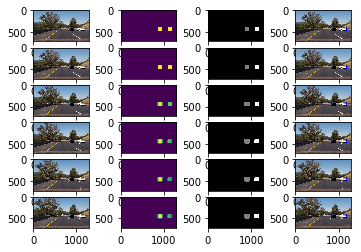

In [62]:
# apply find_cars_draw to each from of the input video and create an output video with the bounding boxes overlaid.
# heatmap based label integrated over x last frames

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vidfig = plt.figure()
frame_i = 0

video_output = 'project_video.mp4'
test_vid = VideoFileClip("test_video.mp4")
op_vid = test_vid.fl_image(process_cars)
%time op_vid.write_videofile(video_output, audio=False)

plt.savefig('output_images/image_5.png', bbox_inches='tight')

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))